In [41]:
import MDAnalysis as mda
import numpy as np
import sys
import matplotlib.pyplot as plt
nav = mda.units.N_Avogadro

with open ('electrons.dat') as f:
    rawdata = f.read().split('\n')
    lines= rawdata[0:len(rawdata)-1]
    tmp_atoms = np.asarray([l.split()[0:2] for l in lines])
    electrons = dict([ (elem[0],int(elem[1])) for elem in tmp_atoms])
    
import time
import gc
gc.collect()

20462

In [2]:
start_time=time.time()
u=mda.Universe("prod.tpr","centered.xtc")
print("Loading the trajectory in {} s".format(time.time()-start_time))
start_time=time.time()
wght=np.zeros(u.atoms.names.shape[0])
for i in range (0,u.atoms.names.shape[0]):
    wght[i]=electrons[u.atoms.names[i]]
    
print("Creating electron dictonary in {} s".format(time.time()-start_time))    

Loading the trajectory in 0.5531504154205322 s
Creating electron dictonary in 150.50295090675354 s


In [9]:
for ts in u.trajectory[9:15:1]:
    print(ts.frame)

9
10
11
12
13
14


In [83]:
class FormFactor(object):
    def __init__(self, conf,traj,nbin,bsize,output):
        path = "/home/ricky/Downloads/"
        self.conf = conf
        self.traj = traj
        start_time=time.time()
        self.u = mda.Universe(self.conf,self.traj)
        print("Loading the trajectory takes {:10.6f} s".format(time.time()-start_time))
        
        #self.u = u
        
        #number of bins
        self.nbin = nbin
        #the totatl box size in [nm]
        self.bsize = bsize
        
        self.output = output
        #self.calculate_weight()
        self.wght=wght

        self.calculate_density()
        #self.plot_density()
        #self.plot_fourier_run()
        #self.plot_fourier_final()

    #read the atomic names, and number of electrons;
    #make the dictonary of atom name and number of electrons for POPC molecule  and water
    def calculate_weight(self):
        start_time=time.time()
        with open ('electrons.dat') as f:
            rawdata = f.read().split('\n')
            lines= rawdata[0:len(rawdata)-1]
            tmp_atoms = np.asarray([l.split()[0:2] for l in lines])
            electrons = dict([ (elem[0],int(elem[1])) for elem in tmp_atoms])
        print("Loading of electron mapping takes {:10.6f} s".format(time.time()-start_time))
        
        #weights to calculate the electron density
        start_time=time.time()
        wght=np.zeros(self.u.atoms.names.shape[0])
        for i in range (0,self.u.atoms.names.shape[0]):
            wght[i]=electrons[self.u.atoms.names[i]]
        self.wght=wght    
        print("Creating the electron mapping dictonary takes {:10.6f} s".format(time.time()-start_time))

    def calculate_density(self):

        
        c = self.u.select_atoms('resname POPC')
        
        
        box_z = self.u.dimensions[2]
        d =  2*self.bsize/ self.nbin #     # bin width
        boxH = self.bsize
        x = np.linspace(-boxH,boxH,self.nbin+1)[:-1] + d/2
        fx = np.zeros(self.nbin)
        fa=[]
        fb=[]

        """Calculte density profiles and FF from individual frames"""
        start_time=time.time()
        min_z=10000000
        for ts in self.u.trajectory:
            #count the index of the frame, numbered from 0, used to be used for the density profile averaging
            #posible not needed now
            frame = ts.frame
            
            #print(frame)
            

            
            #reads the dimension in z-direction
            box_z = ts.dimensions[2]
            if box_z/10<min_z:
                min_z=box_z/10
            
            #print(min_z)

            
            #reads the coordinates of all of the atoms
            crds = self.u.atoms.positions
            
            #calculates the center of mass of the selected atoms that the density should be centered around and 
            #takes the z-coordinate value
            ctom = c.atoms.center_of_mass()[2]
            
            #moves the center of mass of the selected centering group into box/2
            crds[:,2] += box_z/2 - ctom
            
            """shifts the coordinates in the universe by the value of the center of mass"""
            self.u.atoms.positions = crds
            
            """puts the atoms back to the original box dimension; it possibly does not take PBC into account
            #therefore it may brake some of the water molecules; try it, come to the issue later"""
            self.u.atoms.pack_into_box()
            
            """shif the coordinates so that the center in z-dimention is in 0; 
            #divide by 10 to get the coordinates in nm, since now the crds are only the z coordinates"""
            crds = (self.u.atoms.positions[:,2] - box_z/2)/10
            
            #gets the box-z size in nm
            box_z /= 10
            
            """calculates the volume of the bin; d- the "height" of a bin; assumes in [nm] """
            # ts.dimension[0], ts.dimension[1] - the x and y dimension; in [A] --> devides by 100
            vbin = d*np.prod(ts.dimensions[:2])/100
            
            #start_time2=time.time()

            d_ff =  box_z/ self.nbin
            vbin_FF =d_ff*np.prod(ts.dimensions[:2])/100    
            ff_density=np.histogram(crds,bins=self.nbin,range=(-box_z/2,box_z/2),weights=self.wght/vbin_FF)[0]
            FF_range = np.linspace(0,999,1000)  
            fa_run,fb_run=self.fourier(ff_density,ts.dimensions[2]/10,FF_range,d_ff)
            
            """Do running ff - seems to produce consistent results"""
            fourrier_result2= np.sqrt(np.multiply(fa_run,fa_run)+np.multiply(fb_run,fb_run))
            fourrier_data2 = np.vstack((FF_range*0.1*0.01,fourrier_result2)).transpose()
            #self.plot_fourier_final(fourrier_data2)

            
            fa.append(fa_run)
            fb.append(fb_run)
            #print("One furier loop takes {:10.6f} s".format(time.time()-start_time2))
          
            """Calculate and plot running densities"""
            #ff_x = np.linspace(-box_z/2,box_z/2,ff_density.shape[0]+1)[:-1] + box_z/(2*ff_density.shape[0])
            #data_density_ff=np.stack((ff_x,ff_density)).transpose()
            #self.plot_density(data_density_ff)
            #with open(str(self.output)+"running_density", 'wb') as f:
            #    np.savetxt(f, data_density_ff,fmt='%8.4f  %.8f')
         

            """calculates the total density profile; keep for now"""
            fx += np.histogram(crds,bins=self.nbin,range=(-boxH,boxH),weights=self.wght/vbin)[0]
            #fx += np.histogram(crds,bins=self.nbin,range=(-boxH,boxH),weights=self.u.atoms.masses/vbin)[0]
        print("Calculating the density takes {:10.6f} s".format(time.time()-start_time))


        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        """ Normalizing the profiles """
        fx /= (frame+1) 
        
        

        """ Symmetrizing profile if necessary """
        #if args.symmetrize :
        #    fx += fx[::-1]
        #    fx /=2


        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        """ Post-processign data and writing to file """
        density_data = np.vstack((x,fx)).transpose()
        
        
        """Post-processing of FF data from individual runs"""
        
        fa_run = np.average(fa,axis=0)
        fb_run = np.average(fb,axis=0)
        fa_err = np.std(fa,axis=0)/np.sqrt(frame+1)
        fb_err = np.std(fb,axis=0) /np.sqrt(frame+1)
        
        fourrier_result= np.sqrt(np.multiply(fa_run,fa_run)+np.multiply(fb_run,fb_run))
        #calculate error (fa*fa_err + fb*fb_err)/ sqrt(fa^2+fb^2)
        fourrier_error= np.multiply(1/(np.multiply(fa_run,fa_err)+np.multiply(fb_run,fb_err)),fourrier_result)
        fourrier_data= np.vstack((FF_range*0.1*0.01,fourrier_result,fourrier_error)).transpose()
        
    
        
        
       
        """Get the indexes of the final density data where all the time steps contribute
        In other words, take the coordinates of the smalest box from the simulation"""
        final_FF_start=int(np.round(self.nbin/2-min_z/d/2))+1
        final_FF_end=int(np.round(self.nbin/2+min_z/d/2))-1
        
  
        
        fa_aver, fb_aver = self.fourier(density_data[final_FF_start:final_FF_end,1],density_data[final_FF_end,0]-density_data[final_FF_start,0],FF_range,density_data[1,0]-density_data[0,0])
        
        """Plot density profiles from the average density with minimal box"""
        self.plot_density(density_data[final_FF_start:final_FF_end,:])
        self.plot_density(density_data)
        fourrier_result2= np.sqrt(np.multiply(fa_aver,fa_aver)+np.multiply(fb_aver,fb_aver))
        fourrier_data2 = np.vstack((FF_range*0.1*0.01,fourrier_result2)).transpose()
        self.plot_fourier_final_run(fourrier_data,fourrier_data2)
        
        print(fourrier_data)
        print(fourrier_data2)

        with open(str(self.output)+".finalDensity", 'wb') as f:
            np.savetxt(f, density_data[final_FF_start+1:final_FF_end-1,:],fmt='%8.4f  %.8f')
        
        """Save data into files"""
        with open(self.output, 'wb') as f:
            np.savetxt(f, density_data,fmt='%8.4f  %.8f')
            
        with open(str(self.output)+".fourierFromEveryFrame", 'wb') as f:
            np.savetxt(f, fourrier_data,fmt='%8.4f  %.8f %.8f')
        
        with open(str(self.output)+".fourierFromFinalDensity", 'wb') as f:
            np.savetxt(f, fourrier_data2,fmt='%8.4f  %.8f')
  
        
        
    def plot_density(self,data):
        #data=np.loadtxt(self.output)
        plt.figure(figsize=(15, 6))
        plt.plot(data[:,0],data[:,1])
        plt.xlabel("Membrane normal [nm]")
        plt.show()
        
    def plot_fourier_run(self):
           
        data=np.loadtxt(str(self.output)+".fourier")
        plt.figure(figsize=(15, 6))
        plt.plot(data[:,0],data[:,1])
        #plt.plot(data[:,0],fourrier_result)
        #plt.errorbar(data[:,0],data[:,1],yerr=data[:,2])
        plt.xlabel("Membrane normal [nm]")
        plt.show()
    
    def plot_fourier_final(self,data):
        plt.figure(figsize=(15, 6))
        plt.plot(data[:,0],data[:,1])
        plt.xlabel("q [A]")
        plt.show()
        
    def plot_fourier_final_run(self,data,data2):
        plt.figure(figsize=(15, 6))
        plt.plot(data[:,0],data[:,1])
        plt.errorbar(data[:,0],data[:,1],data[:,2])
        plt.plot(data2[:,0],data2[:,1])
        plt.xlabel("q [A]")
        plt.show()
        
    
    def fourier(self,ff_density,box_z,FF_range,d_ff):
        """Calculates fourier transform of ff_density in the FF_range"""
        #calculate a "height" of a bin for FF puroposes; in this case the number of bins is constant and the 
        #bin width changes
        
        
        """Creates the direct space coordinates"""
        #the calculations are stable with rounding (and others) errors in the direct space coordinates
        ff_x = np.linspace(-box_z/2,box_z/2,ff_density.shape[0]+1)[:-1] + box_z/(2*ff_density.shape[0])
        ff_x2 = np.linspace(-box_z/2,box_z/2,ff_density.shape[0]+1)[:-1] + d_ff/2
             
        
        k=0
        bulk=0
        while k*d_ff<0.33:
            bulk+=ff_density[k]+ff_density[-k-1]
            #print("The densities from the left and right ends are: {} {}".format(ff_density[k],ff_density[-k-1]))
            k+=1
        bulk/=(2*k)
        #print("The bulk density is {}".format(bulk))

            
        fa=np.zeros(FF_range.shape[0])
        fb=np.zeros(FF_range.shape[0])

        
        for j in range (0,ff_density.shape[0]):
            fa+=(ff_density[j]-bulk)*np.cos(FF_range*ff_x[j]*0.01)*d_ff
            fb+=(ff_density[j]-bulk)*np.sin(FF_range*ff_x[j]*0.01)*d_ff
            
 

        return fa, fb
 
               



Loading the trajectory takes   0.514663 s
Calculating the density takes  64.779855 s


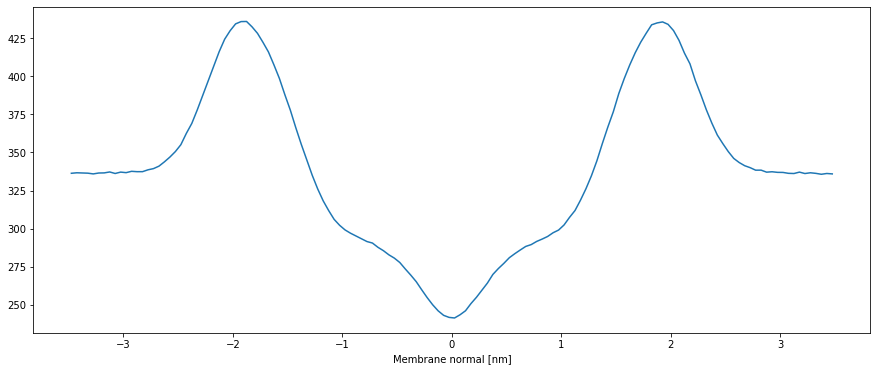

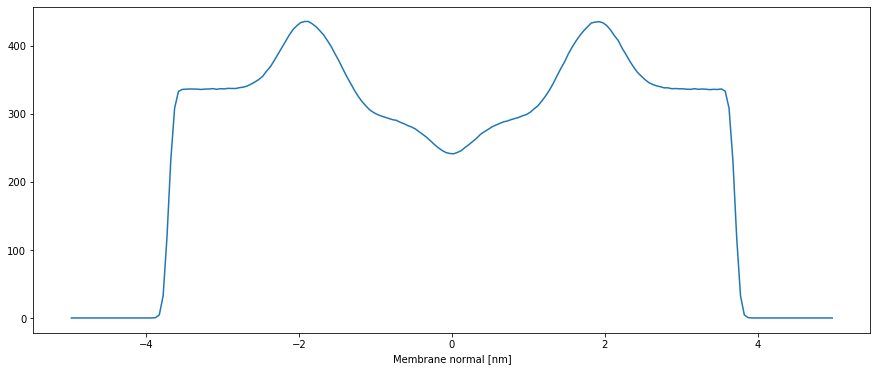

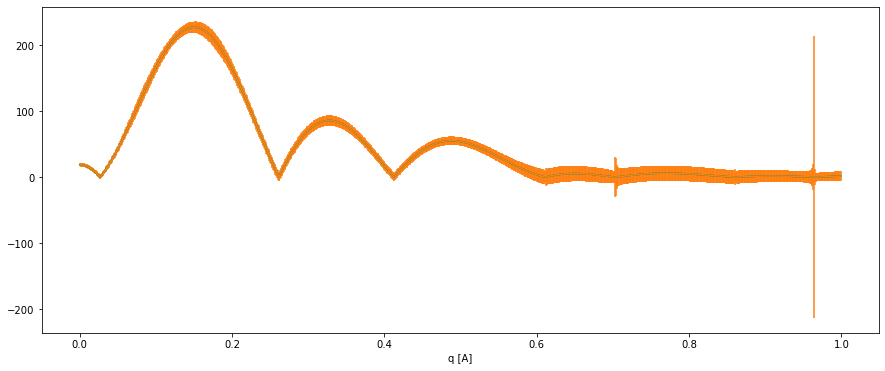

[[ 0.00000000e+00  1.90281507e+01  2.80499538e+00]
 [ 1.00000000e-03  1.90009298e+01  2.80556173e+00]
 [ 2.00000000e-03  1.89192792e+01  2.80726165e+00]
 ...
 [ 9.97000000e-01  1.49116080e+00 -7.44041347e+00]
 [ 9.98000000e-01  1.53337906e+00 -7.45102650e+00]
 [ 9.99000000e-01  1.57512155e+00 -7.46163515e+00]]
[[0.00000000e+00 1.84182773e+01]
 [1.00000000e-03 1.83911895e+01]
 [2.00000000e-03 1.83099382e+01]
 ...
 [9.97000000e-01 1.46580999e+00]
 [9.98000000e-01 1.50699045e+00]
 [9.99000000e-01 1.54773246e+00]]


In [84]:
FormFactor('prod.tpr',"centered.xtc",200,5,'new_test_frame40')


Loading the trajectory takes   0.651022 s
40


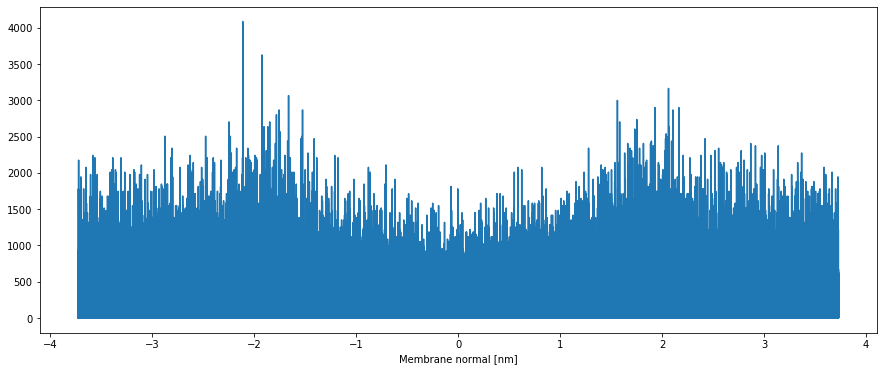

Calculating the density takes   1.469273 s


/home/ricky/anaconda3/envs/all3/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: divide by zero encountered in true_divide


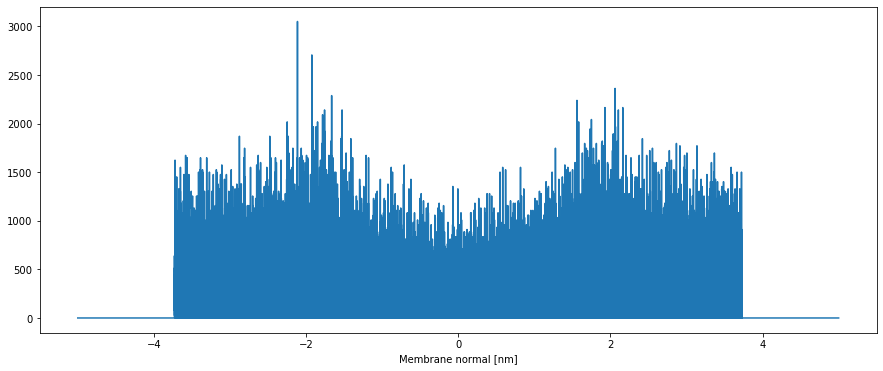

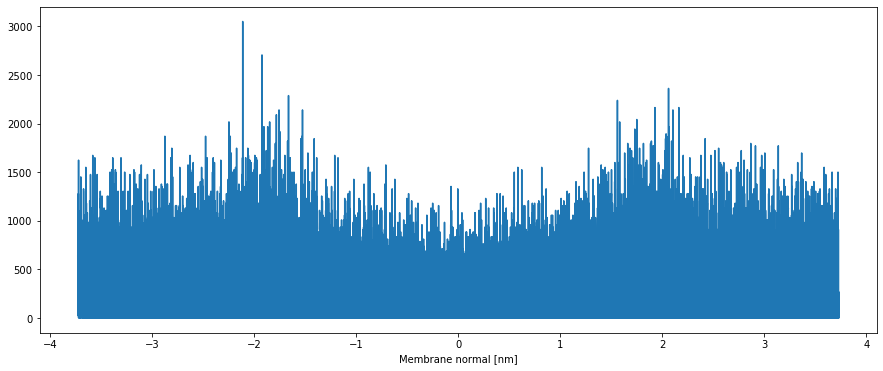

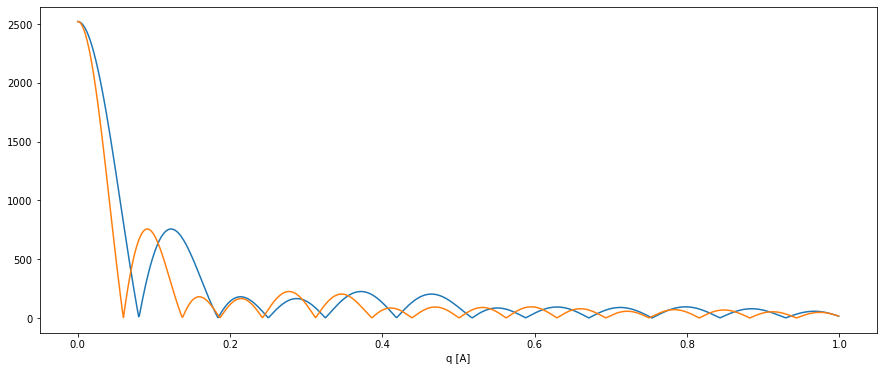

In [81]:
FormFactor('prod.tpr',"centered.xtc",20000,5,'Hannes_trajectory_ts40_20000bins')


Loading the trajectory takes   0.447775 s
Calculating the density takes  66.148261 s


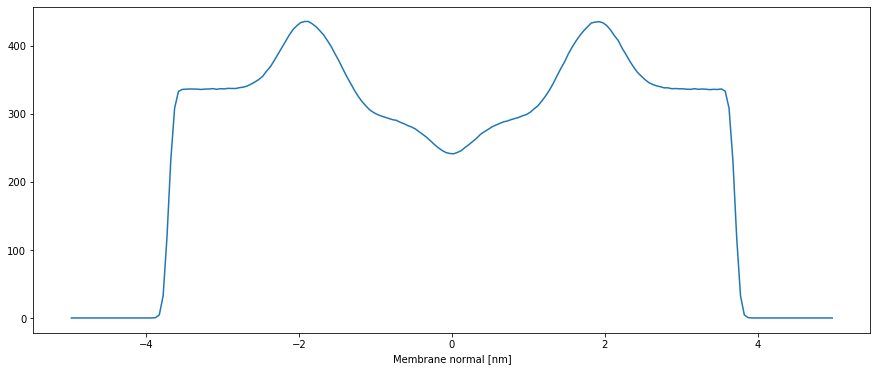

The self.nbin/2 is 100.0
The min_z is 7.475309753417969
The d is 0.05
The min_z/d id 149.50619506835938
The starting box is 25
The ending min box coor is 175


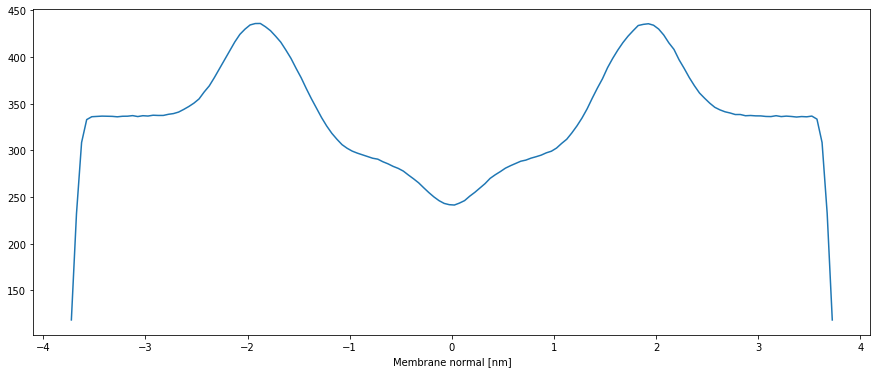

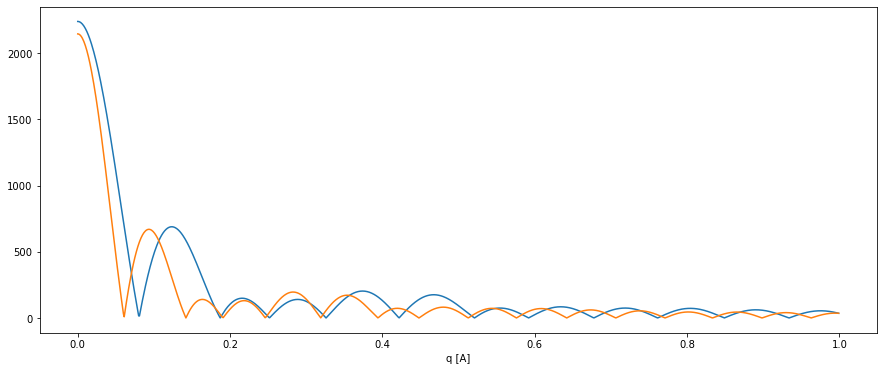

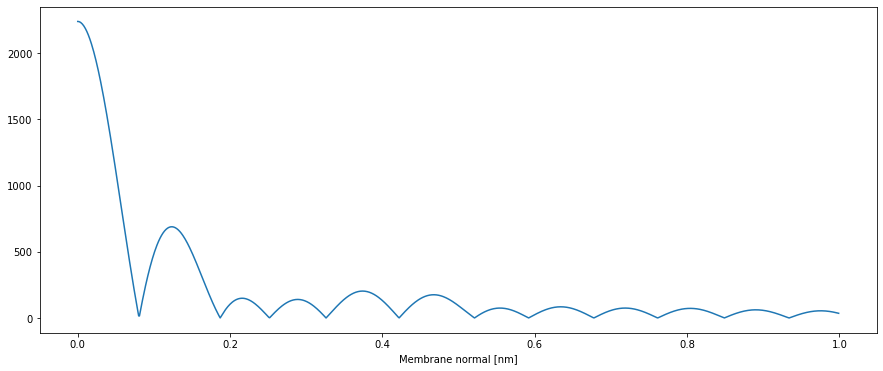

In [53]:
FormFactor('prod.tpr',"centered.xtc",200,5,'Hannes_trajectory')


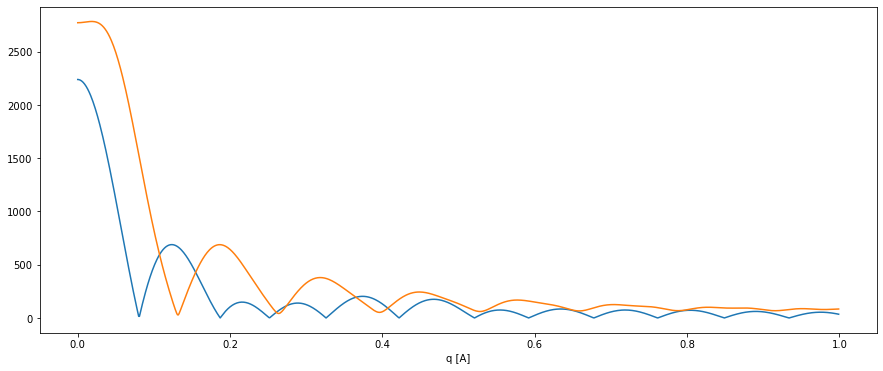

In [30]:
data=np.loadtxt("Hannes_trajectory.fourierFromEveryFrame")
data2=np.loadtxt("Hannes_trajectory.fourierFromFinalDensity")
plt.figure(figsize=(15, 6))
plt.plot(data[:,0],data[:,1])
plt.plot(data2[:,0],8*data2[:,1])
        #plt.plot(data[:,0],fourrier_result)
        #plt.errorbar(data[:,0],data[:,1],yerr=data[:,2])
plt.xlabel("q [A]")
plt.show()

In [251]:
data=np.loadtxt("electronDENSITY_PN_model_310K_TIP3P_no_ions.xvg")
FF_range = np.linspace(0,999,1000)  


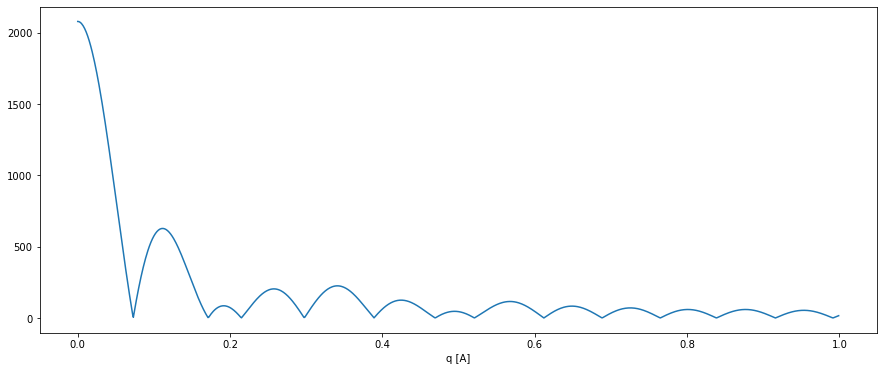

In [258]:
fa_aver, fb_aver = FormFactor.fourier(3,data[:,1],data[-1,0]-data[0,0],FF_range,data[1,0]-data[0,0])

fourrier_result2= np.sqrt(np.multiply(fa_aver,fa_aver)+np.multiply(fb_aver,fb_aver))
fourrier_data2 = np.vstack((FF_range*0.1*0.01,fourrier_result2)).transpose()
FormFactor.plot_fourier_final(1,fourrier_data2)
 

In [191]:
FormFactor('prod.tpr',"centered.xtc",200,5,'Hannes_trajectory')


Loading the trajectory takes   0.473338 s
One furier loop takes   0.016134 s
One furier loop takes   0.016382 s
One furier loop takes   0.016773 s
One furier loop takes   0.017058 s
One furier loop takes   0.017312 s
One furier loop takes   0.017834 s
One furier loop takes   0.016702 s
One furier loop takes   0.018224 s
One furier loop takes   0.016520 s
One furier loop takes   0.016407 s
One furier loop takes   0.016870 s
One furier loop takes   0.017485 s
One furier loop takes   0.018167 s
One furier loop takes   0.017960 s
One furier loop takes   0.018505 s
One furier loop takes   0.016657 s
One furier loop takes   0.016642 s
One furier loop takes   0.016813 s
One furier loop takes   0.016564 s
One furier loop takes   0.016569 s
One furier loop takes   0.017525 s
One furier loop takes   0.021228 s
One furier loop takes   0.017367 s
One furier loop takes   0.021861 s
One furier loop takes   0.017813 s
One furier loop takes   0.016641 s
One furier loop takes   0.016415 s
One furier lo

KeyboardInterrupt: 

Loading the trajectory takes   0.444510 s
Calculating the density takes 288.033929 s
[5455236.1877931  5453937.32438569 5450041.78183497 ...  -40421.58821392
  -40149.40395229  -39822.73442561]


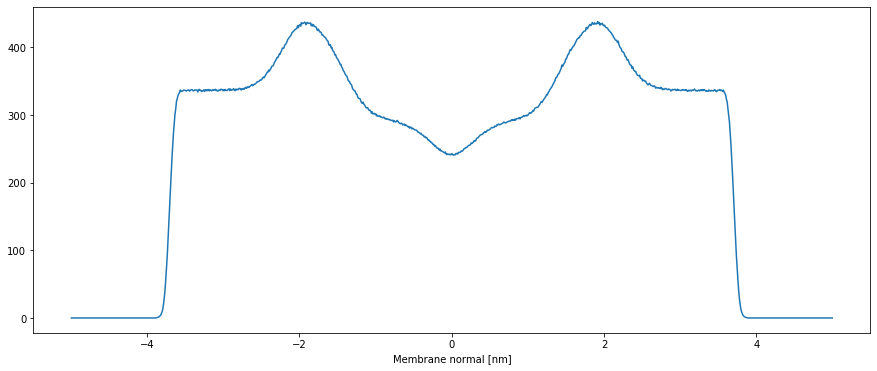

In [146]:
FormFactor('prod.tpr',"centered.xtc",1000,5,'Hannes_trajectory_1000')


Loading the trajectory takes   0.726985 s
Calculating the density takes 343.004064 s
[array([7.63202983e+02, 7.45832278e+02, 6.95141576e+02, ...,
       1.38715132e+00, 8.41818977e-01, 4.11642166e-01]), array([777.4960175 , 759.08991845, 705.42871626, ...,   2.58104142,
         2.71298525,   2.75360134]), array([775.9750049 , 757.85196147, 704.99106269, ...,  -3.94752119,
        -4.37859464,  -4.39000961]), array([776.228104  , 757.8965132 , 704.44956778, ...,  -2.89568122,
        -2.74139251,  -2.25870075]), array([ 7.75379880e+02,  7.57117958e+02,  7.03866698e+02, ...,
        5.48042478e-01, -3.94353197e-01, -1.40722789e+00]), array([779.36257045, 760.93614741, 707.21483376, ...,  -3.32361166,
        -2.90840408,  -2.22081456]), array([ 7.76992592e+02,  7.58551930e+02,  7.04788715e+02, ...,
       -1.38125183e+00, -8.95056003e-01, -3.34941023e-01]), array([7.77595478e+02, 7.59193648e+02, 7.05544784e+02, ...,
       1.79350499e+00, 1.20913360e+00, 7.27295857e-01]), array([ 7.8164

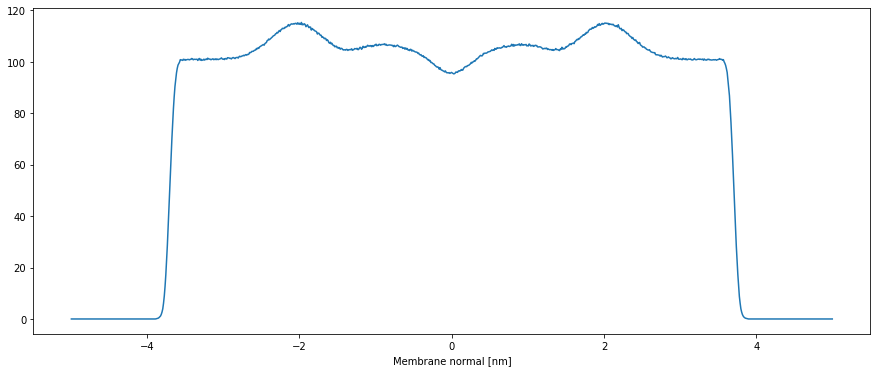

In [194]:
FormFactor('prod.tpr',"centered.xtc",1000,5,'Hannes_trajectory_1000')

Loading the trajectory takes   0.583576 s
Loading of electron mapping takes   0.000587 s
Creating the electron mapping dictonary takes 108.112494 s
Calculating the density takes  37.186899 s


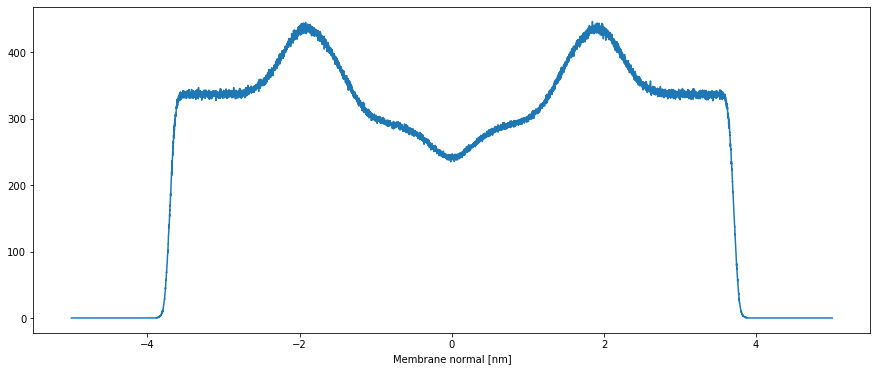

In [101]:
FormFactor('prod.tpr',"centered.xtc",10000,5,'Hannes_trajectory_10000')

Loading the trajectory takes   0.794756 s
Calculating the density takes  38.193627 s


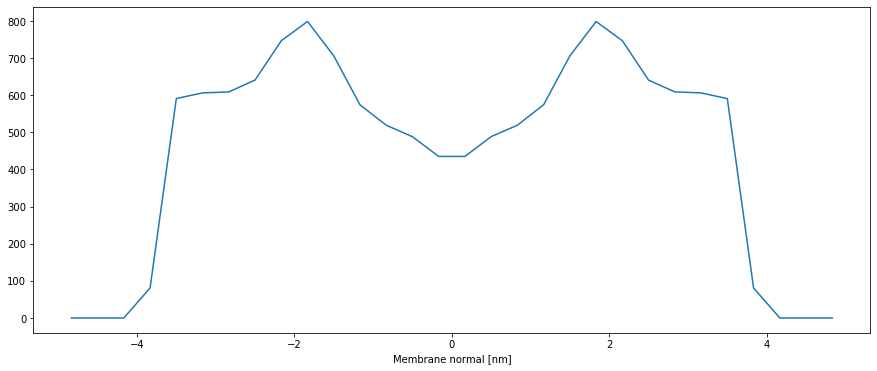

In [170]:
FormFactor('prod.tpr',"centered.xtc",30,5,'Hannes_trajectory_30')

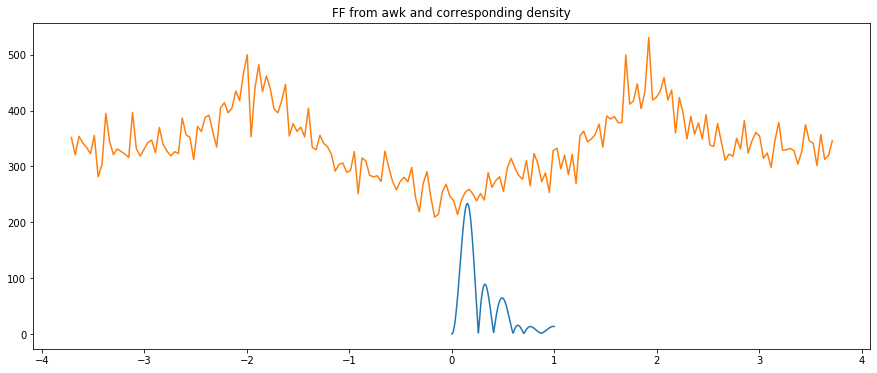

In [8]:
"""try to converge the densities from awk and python"""
#load form factor hopefully calculated from "Hannes_trajectory_ts40_200binsrunning_density" by awk
FF_awk_run=np.loadtxt("test_different_binning/ts40/000-run_dens_200.ff")

#load "Hannes_trajectory_ts40_200binsrunning_density"
density_run=np.loadtxt("test_different_binning/ts40/Hannes_trajectory_ts40_200binsrunning_density")

#plot FF and plot density
plt.figure(figsize=(15, 6))
plt.plot(FF_awk[:,0],FF_awk[:,1])
plt.plot(density_run[:,0],density_run[:,1])
plt.title("FF from awk and corresponding density")
plt.show()


The densities from left and right are: 351.8254204 345.89022118
The densities from left and right are: 320.83049114 319.18182469
The densities from left and right are: 353.80382014 312.58715889
The densities from left and right are: 341.9334217 357.10115304
The densities from left and right are: 333.69008945 301.37622703
The densities from left and right are: 322.80889088 341.60368841
The densities from left and right are: 355.45248659 345.89022118
The densities from left and right are: 281.26249635 374.57701741
The densities from left and right are: 302.69516019 326.43595707
k is 9
The bulk density is equal to 332.7192080966667


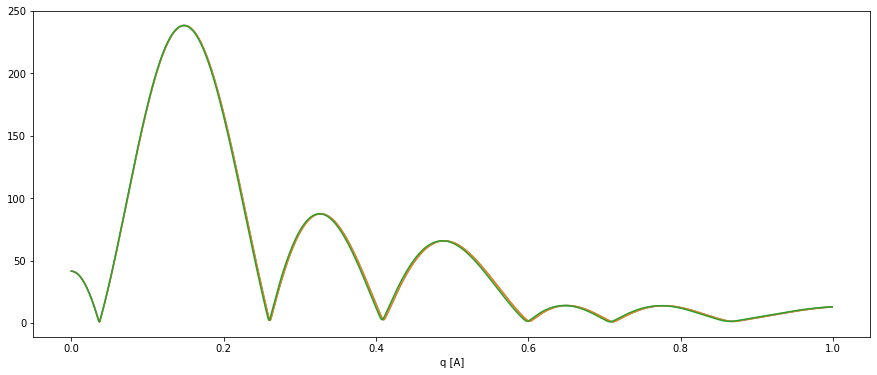

In [39]:
FF_range = np.linspace(0,999,1000)  
fa_aver, fb_aver=FormFactor.fourier(2,density_run[:,1],density_run[-1,0]-density_run[0,0],FF_range,density_run[1,0]-density_run[0,0],density_run[:,0])
fourrier_result2= np.sqrt(np.multiply(fa_aver,fa_aver)+np.multiply(fb_aver,fb_aver))
fourrier_data2 = np.vstack((FF_range*0.1*0.01,fourrier_result2)).transpose()

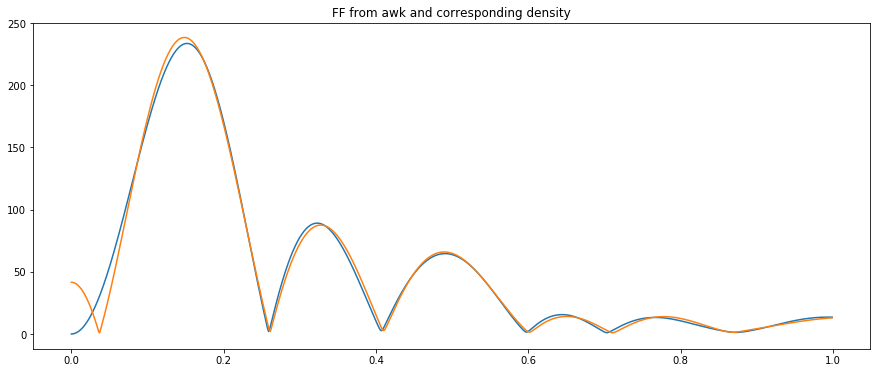

In [40]:
plt.figure(figsize=(15, 6))
plt.plot(FF_awk[:,0],FF_awk[:,1])
plt.plot(fourrier_data2[:,0],fourrier_data2[:,1])
plt.title("FF from awk and corresponding density")
plt.show()


(1000,)